In [9]:
import numpy as np
import cv2 as cv
import sys
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test image')

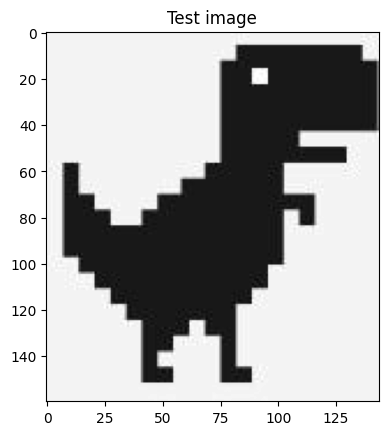

In [10]:
img1 = cv.imread('photo_3_train.jpg', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('photo_3_test2.png', cv.IMREAD_GRAYSCALE) 
plt.imshow(img1, cmap = 'gray')
plt.title('Test image')

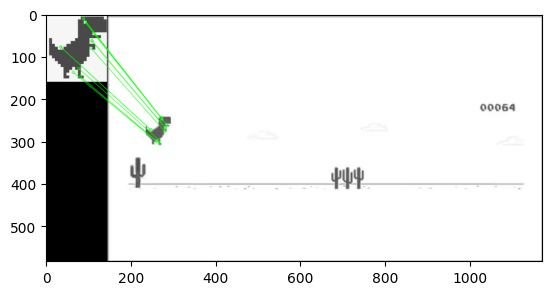

In [11]:
MIN_MATCH_COUNT = 3
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h, w = img1.shape
    pts = np.float32([ [0,0], [0, h-1], [w-1, h-1], [w-1, 0] ]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)

    img2 = cv.polylines(img2, [np.int32(dst)], True, 255,3, cv.LINE_AA)
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), singlePointColor = None, matchesMask = matchesMask, flags = 2)
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

plt.imshow(img3)

In [12]:
def track_object(query_img, frame_img):
    MIN_MATCH_COUNT = 5
    sift = cv.SIFT_create()

    kp1, des1 = sift.detectAndCompute(query_img, None)
    kp2, des2 = sift.detectAndCompute(frame_img, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 3.0)
        matchesMask = mask.ravel().tolist()

        h, w = query_img.shape
        pts = np.float32([ [0,0], [0, h], [w, h], [w, 0] ]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)

        return cv.polylines(frame_img, [np.int32(dst)], True, (0, 0, 255), 3)
        #draw_params = dict(matchColor = (0,255,0), singlePointColor = None, matchesMask = matchesMask, flags = 2)
        #cv.drawMatches(query_img, kp1, frame_img, kp2, good, None, **draw_params)
    else:
        print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
        matchesMask = None
        return frame_img
    


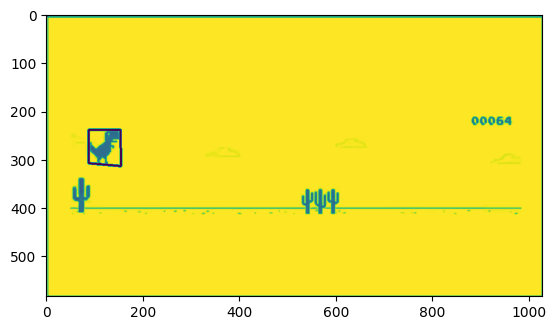

In [13]:
plt.imshow(track_object(img1, img2))

In [14]:
video = cv.VideoCapture('video_3_query.mp4')
cv.namedWindow("window")

if (video.isOpened() == False):
    print("Error opening video file")

frame_width = int(video.get(3))
frame_height = int(video.get(4))

while video.isOpened():
    cv.startWindowThread()
    ret, frame = video.read()
    
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    frame = track_object(img1, cv.cvtColor(frame, cv.IMREAD_GRAYSCALE))
    cv.imshow('frame, click q to quit', frame)

    if cv.waitKey(1) == ord('q'):
        break
    
video.release()
cv.destroyAllWindows()
cv.waitKey(1)

-1

: 